In [ ]:
# Install required dependencies
%pip install mediapipe opencv-python matplotlib tqdm scikit-learn tensorflow

# Mount Google Drive (if your dataset is stored there)
from google.colab import drive
drive.mount('/content/drive/')

# Import necessary libraries
import os
import cv2
import json
import numpy as np
import pandas as pd
import mediapipe as mp
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# MediaPipe Hands setup
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

# ============================================================
# CONFIGURATION PARAMETERS
# ============================================================

# Path configuration
hagrid_base_path = '/content/drive/MyDrive/HandGestures/HAGRID'
output_dir = 'processed_data'
os.makedirs(output_dir, exist_ok=True)

# Model parameters
epochs = 30
batch_size = 32
use_split = 'train_val'
train_size = 0.8
max_samples_per_class = 800

# Define game control gestures
selected_gestures = [
    'fist', 'palm', 'peace', 'ok', 'like', 'dislike', 'stop',
    'one', 'two_up', 'three', 'four', 'mute'
]

# Game control mappings
game_controls = {
    'fist': 'Attack/Punch',
    'palm': 'Move Forward',
    'one': 'Select/Point',
    'like': 'Power Up/Confirm',
    'dislike': 'Crouch/Duck',
    'peace': 'Special Move',
    'ok': 'Pickup Item',
    'stop': 'Pause Game',
    'two_up': 'Jump',
    'three': 'Weapon Switch',
    'four': 'Open Inventory',
    'mute': 'Mute/Silent Mode'
}

# Initialize label encoder
label_encoder = LabelEncoder()
label_encoder.fit(selected_gestures)

LabelEncoder()

In [ ]:
def preprocess_dataset():
    """Preprocess the HAGRID dataset from JSON annotations"""
    print(f"Preprocessing HAGRID dataset for game gesture recognition...")
    print(f"Selected gestures for game control: {selected_gestures}")

    # Check if preprocessed data already exists
    preprocessed_path = os.path.join(output_dir, f"preprocessed_data_{use_split}.pkl")
    if os.path.exists(preprocessed_path):
        print(f"Loading preprocessed data from {preprocessed_path}")
        with open(preprocessed_path, 'rb') as f:
            data = pickle.load(f)
        return data['X_train'], data['X_test'], data['y_train'], data['y_test']

    # Path to annotations split
    split_path = os.path.join(hagrid_base_path, f"ann_{use_split}")
    if not os.path.exists(split_path):
        raise ValueError(f"Split path not found: {split_path}")

    # Data structures to hold landmarks and labels
    all_landmarks = []
    all_labels = []
    expected_landmarks_length = 21 * 3  # MediaPipe hand has 21 landmarks with x,y,z coordinates

    # Get count of samples per class to balance dataset
    class_sample_counts = {gesture: 0 for gesture in selected_gestures}

    # Check if we have a flat structure or a nested structure
    is_flat_structure = any(file.endswith('.json') for file in os.listdir(split_path))

    # Process each selected gesture
    for gesture in selected_gestures:
        print(f"Processing '{gesture}' gesture...")

        if is_flat_structure:
            # Handle flat structure where JSON files are directly in the split directory
            json_files = [f for f in os.listdir(split_path)
                         if f.endswith('.json') and f.startswith(gesture)]
            gesture_path = split_path
        else:
            # Handle nested structure where JSON files are in subdirectories
            gesture_path = None
            for folder in os.listdir(split_path):
                if folder.startswith(gesture):
                    gesture_path = os.path.join(split_path, folder)
                    break

            if not gesture_path:
                print(f"Warning: Could not find directory for '{gesture}'")
                continue

            # Get all JSON files
            json_files = [f for f in os.listdir(gesture_path) if f.endswith('.json')]

        print(f"  Found {len(json_files)} JSON files for '{gesture}'")

        # Process each JSON file to extract landmarks
        for json_file in tqdm(json_files):
            # Stop if we have enough samples for this class
            if class_sample_counts[gesture] >= max_samples_per_class:
                break

            json_path = os.path.join(gesture_path, json_file)

            # Load JSON annotations
            try:
                with open(json_path, 'r') as f:
                    annotations = json.load(f)
            except Exception as e:
                print(f"Error loading {json_path}: {e}")
                continue

            # Process each image annotation in the JSON file
            for img_id, img_data in annotations.items():
                # Skip if no landmarks or not the target gesture
                if 'landmarks' not in img_data or 'labels' not in img_data:
                    continue

                # Skip if we have enough samples for this class
                if class_sample_counts[gesture] >= max_samples_per_class:
                    break

                # Find hand with the target gesture
                target_idx = None
                for i, label in enumerate(img_data['labels']):
                    if label == gesture:
                        target_idx = i
                        break

                if target_idx is None:
                    continue

                # Check if landmarks exist for this hand
                if len(img_data['landmarks']) <= target_idx:
                    continue

                # Extract landmarks for the target hand
                hand_landmarks = img_data['landmarks'][target_idx]

                # Validate landmarks
                if len(hand_landmarks) != 21:  # MediaPipe hand has 21 landmarks
                    # Skip if wrong number of landmarks
                    continue

                # Convert to flattened feature vector
                landmarks_flat = []
                for landmark in hand_landmarks:
                    if len(landmark) != 2:  # Should have x and y coordinates
                        # Skip this sample if landmark structure is incorrect
                        break
                    landmarks_flat.extend(landmark)  # [x, y] for each landmark

                # Skip if we broke out of the loop due to incorrect landmark structure
                if len(landmarks_flat) != 21 * 2:
                    continue

                # Add z-coordinate as 0 (since HAGRID provides only x,y)
                # This makes it compatible with MediaPipe's 3D landmarks format
                landmarks_3d = []
                for i in range(0, len(landmarks_flat), 2):
                    landmarks_3d.extend([landmarks_flat[i], landmarks_flat[i+1], 0.0])

                # Ensure consistent length
                if len(landmarks_3d) != expected_landmarks_length:
                    continue

                all_landmarks.append(landmarks_3d)
                all_labels.append(gesture)
                class_sample_counts[gesture] += 1

    # Print class statistics
    print("\nCollected samples per class:")
    for gesture, count in class_sample_counts.items():
        print(f"  {gesture}: {count}")

    # Convert to numpy arrays - ensure all landmark arrays have the same shape first
    if not all_landmarks:
        raise ValueError("No valid landmark data was collected. Check dataset format.")

    # Convert to numpy arrays
    X = np.array(all_landmarks)
    y = np.array(all_labels)

    # Encode labels
    # Check if label_encoder is already fitted
    if not hasattr(label_encoder, 'classes_'):
        y_encoded = label_encoder.fit_transform(y)
    else:
        y_encoded = label_encoder.transform(y)

    # Save label encoder
    with open(os.path.join(output_dir, 'label_encoder.pkl'), 'wb') as f:
        pickle.dump(label_encoder, f)

    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded,
        test_size=1-train_size,
        random_state=42,
        stratify=y_encoded
    )

    # Save preprocessed data
    with open(preprocessed_path, 'wb') as f:
        pickle.dump({
            'X_train': X_train,
            'X_test': X_test,
            'y_train': y_train,
            'y_test': y_test,
            'classes': label_encoder.classes_
        }, f)

    print(f"Preprocessed data saved to {preprocessed_path}")
    print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")
    print(f"Feature dimensions: {X_train.shape[1]}")

    return X_train, X_test, y_train, y_test

In [ ]:

# ============================================================
# STEP 3: BUILD AND TRAIN MODEL
# ============================================================

def build_model(input_shape, num_classes):
    """Build the neural network model architecture"""
    model = tf.keras.Sequential([
        # Input layer
        tf.keras.layers.Input(shape=(input_shape,)),

        # Normalization
        tf.keras.layers.BatchNormalization(),

        # First hidden layer
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.3),

        # Second hidden layer
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.3),

        # Third hidden layer
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.2),

        # Output layer
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

def train_model(X_train, X_test, y_train, y_test):
    """Train the model and return the trained model and history"""
    # Build model
    num_classes = len(label_encoder.classes_)
    model = build_model(X_train.shape[1], num_classes)

    # Model summary
    model.summary()

    # Setup callbacks
    model_path = os.path.join(output_dir, 'game_gesture_model.h5')
    callbacks = [
        ModelCheckpoint(
            model_path,
            monitor='val_accuracy',
            mode='max',
            save_best_only=True,
            verbose=1
        ),
        EarlyStopping(
            monitor='val_accuracy',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5,
            min_lr=1e-6,
            verbose=1
        )
    ]

    # Train model
    print(f"\nTraining the game gesture recognition model...")
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )

    # Save the Keras model to an .h5 file
    model_path = '/content/drive/MyDrive/HandGestures/game_gesture_model.h5'
    model.save(model_path)
    print(f"Model saved to {model_path}")

    # Evaluate model
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f"\nTest accuracy: {test_accuracy:.4f}")

    return model, history

In [ ]:
# ============================================================
# STEP 4: VISUALIZE RESULTS
# ============================================================

def plot_training_history(history):
    """Plot the training history curves"""
    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'training_history.png'))
    plt.show()

def plot_confusion_matrix(model, X_test, y_test):
    """Generate and display the confusion matrix"""
    # Predict on test data
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred_classes)
    class_names = label_encoder.classes_

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues', values_format='d')
    plt.title('Confusion Matrix - Game Gesture Recognition')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'confusion_matrix.png'))
    plt.show()

def save_game_mappings():
    """Save and display the gesture to game control mappings"""
    mappings_df = pd.DataFrame({
        'Gesture': list(game_controls.keys()),
        'Game Control': list(game_controls.values())
    })
    mappings_df.to_csv(os.path.join(output_dir, 'game_control_mappings.csv'), index=False)
    print(f"\nGame control mappings saved to {output_dir}/game_control_mappings.csv")

    # Display mappings
    display(mappings_df)


In [ ]:

# ============================================================
# STEP 5: TEST MODEL ON JSON FILE
# ============================================================

def test_on_json_annotations(model, json_file_path):
    """Test the model on JSON annotations from the HAGRID dataset"""
    # Load JSON annotations
    try:
        with open(json_file_path, 'r') as f:
            annotations = json.load(f)
    except Exception as e:
        print(f"Error loading {json_file_path}: {e}")
        return

    print(f"\nTesting model on {len(annotations)} annotations from {json_file_path}")

    # Results summary
    results = []

    # Process each annotation
    for img_id, img_data in list(annotations.items())[:10]:  # Process first 10 for demo
        if 'labels' not in img_data or 'landmarks' not in img_data:
            continue

        # Extract landmarks for each hand in the image
        for i, (label, landmarks) in enumerate(zip(img_data['labels'], img_data['landmarks'])):
            # Skip if no gesture
            if label == 'no_gesture':
                continue

            # Convert landmarks to model input format
            landmarks_flat = []
            for landmark in landmarks:
                landmarks_flat.extend(landmark)

            # Add z-coordinate
            landmarks_3d = []
            for j in range(0, len(landmarks_flat), 2):
                landmarks_3d.extend([landmarks_flat[j], landmarks_flat[j+1], 0.0])

            # Make prediction
            prediction = model.predict(np.array([landmarks_3d]), verbose=0)
            predicted_idx = np.argmax(prediction[0])
            confidence = prediction[0][predicted_idx]
            predicted_gesture = label_encoder.inverse_transform([predicted_idx])[0]

            # Get game control
            game_action = game_controls.get(predicted_gesture, "No action")

            # Store result
            results.append({
                'image_id': img_id,
                'true_gesture': label,
                'predicted_gesture': predicted_gesture,
                'confidence': confidence,
                'game_action': game_action,
                'correct': label == predicted_gesture
            })

            # Display result
            print(f"Image ID: {img_id}, Hand #{i+1}")
            print(f"  True gesture: {label}")
            print(f"  Predicted gesture: {predicted_gesture} (confidence: {confidence:.2f})")
            print(f"  Game action: {game_action}")
            print(f"  Correct: {label == predicted_gesture}")
            print()

    # Calculate accuracy
    if results:
        accuracy = sum(r['correct'] for r in results) / len(results)
        print(f"\nTest accuracy on {len(results)} samples: {accuracy:.4f}")

        # Create a DataFrame for better visualization
        results_df = pd.DataFrame(results)
        display(results_df)

    return results

In [ ]:

# ============================================================
# STEP 6: REAL-TIME WEBCAM RECOGNITION
# ============================================================

def run_webcam_recognition(model):
    """Run gesture recognition using webcam with JavaScript API in Colab"""
    print("Setting up webcam for gesture recognition in Colab...")

    # Colab-specific code for webcam access
    from IPython.display import display, Javascript, HTML
    from google.colab.output import eval_js
    from base64 import b64decode

    # JavaScript for accessing webcam and capturing frames
    js_code = """
    async function setupCamera() {
      const video = document.createElement('video');
      video.style.display = 'none';
      document.body.appendChild(video);

      const stream = await navigator.mediaDevices.getUserMedia({
        'audio': false,
        'video': {
          facingMode: 'user',
          width: 640,
          height: 480
        }
      });

      video.srcObject = stream;

      return new Promise((resolve) => {
        video.onloadedmetadata = () => {
          video.play();
          resolve(video);
        };
      });
    }

    async function captureFrame(video) {
      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      const dataUrl = canvas.toDataURL('image/jpeg', 0.8);
      return dataUrl;
    }

    var video = null;
    var stopCamera = false;

    async function runGestureRecognition() {
      if (!video) {
        video = await setupCamera();
      }

      while (!stopCamera) {
        const frameDataUrl = await captureFrame(video);
        const result = google.colab.kernel.invokeFunction(
            'processFrame', [frameDataUrl], {});
        await sleep(100); // Adjust for performance
      }

      // Clean up
      const stream = video.srcObject;
      const tracks = stream.getTracks();
      tracks.forEach(track => track.stop());
    }

    function stopGestureRecognition() {
      stopCamera = true;
    }

    function sleep(ms) {
      return new Promise(resolve => setTimeout(resolve, ms));
    }

    runGestureRecognition();
    """

    # Function to process frames from JavaScript
    def process_frame(frame_data_url):
        # Decode the base64 image
        image_data = b64decode(frame_data_url.split(',')[1])
        image_np = np.frombuffer(image_data, np.uint8)
        image = cv2.imdecode(image_np, cv2.IMREAD_COLOR)

        # Process with MediaPipe
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        with mp_hands.Hands(
            static_image_mode=False,
            max_num_hands=1,
            min_detection_confidence=0.5) as hands:

            results = hands.process(image_rgb)

            predicted_gesture = "No hand detected"
            game_action = "No action"
            confidence = 0.0

            # If hand detected, process landmarks
            if results.multi_hand_landmarks:
                # Draw landmarks
                for hand_landmarks in results.multi_hand_landmarks:
                    mp_drawing.draw_landmarks(
                        image, hand_landmarks, mp_hands.HAND_CONNECTIONS)

                # Extract landmarks for prediction
                landmarks_flat = []
                for landmark in results.multi_hand_landmarks[0].landmark:
                    landmarks_flat.extend([landmark.x, landmark.y, landmark.z])

                # Make prediction
                prediction = model.predict(np.array([landmarks_flat]), verbose=0)
                predicted_idx = np.argmax(prediction[0])
                confidence = prediction[0][predicted_idx]
                predicted_gesture = label_encoder.inverse_transform([predicted_idx])[0]
                game_action = game_controls.get(predicted_gesture, "No action")

            # Display prediction info
            cv2.putText(image, f"Gesture: {predicted_gesture}", (10, 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

            if confidence > 0:
                cv2.putText(image, f"Confidence: {confidence:.2f}", (10, 60),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

            cv2.putText(image, f"Game action: {game_action}", (10, 90),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

            # Display frame
            cv2_imshow(image)
            output.clear()

        return predicted_gesture

    # Register the callback function
    from google.colab import output
    output.register_callback('processFrame', process_frame)

    # Display the webcam feed
    from google.colab.patches import cv2_imshow

    # Start the webcam capture
    display(Javascript(js_code))

    # Display stop button
    display(HTML('<button onclick="stopGestureRecognition()">Stop Recognition</button>'))

STARTING HAGRID GAME GESTURE RECOGNITION PIPELINE
Preprocessing HAGRID dataset for game gesture recognition...
Selected gestures for game control: ['fist', 'palm', 'peace', 'ok', 'like', 'dislike', 'stop', 'one', 'two_up', 'three', 'four', 'mute']
Loading preprocessed data from processed_data/preprocessed_data_train_val.pkl


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ batch_normalization_2                │ (None, 63)                  │             252 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 512)                 │          32,768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 12)                  │           1,548 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 198,792 (776.53 KB)

 Trainable params: 198,666 (776.04 KB)

 Non-trainable params: 126 (504.00 B)


Training the game gesture recognition model...
Epoch 1/30
238/240 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2560 - loss: 2.1436
Epoch 1: val_accuracy improved from -inf to 0.46146, saving model to processed_data/game_gesture_model.h5


240/240 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.2574 - loss: 2.1389 - val_accuracy: 0.4615 - val_loss: 1.4508 - learning_rate: 0.0010
Epoch 2/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5936 - loss: 1.0611
Epoch 2: val_accuracy improved from 0.46146 to 0.78594, saving model to processed_data/game_gesture_model.h5


240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5936 - loss: 1.0608 - val_accuracy: 0.7859 - val_loss: 0.6180 - learning_rate: 0.0010
Epoch 3/30
238/240 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6878 - loss: 0.7883
Epoch 3: val_accuracy improved from 0.78594 to 0.81719, saving model to processed_data/game_gesture_model.h5


240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6880 - loss: 0.7877 - val_accuracy: 0.8172 - val_loss: 0.4759 - learning_rate: 0.0010
Epoch 4/30
233/240 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7346 - loss: 0.6703
Epoch 4: val_accuracy improved from 0.81719 to 0.85781, saving model to processed_data/game_gesture_model.h5


240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7349 - loss: 0.6693 - val_accuracy: 0.8578 - val_loss: 0.3783 - learning_rate: 0.0010
Epoch 5/30
237/240 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7520 - loss: 0.6259
Epoch 5: val_accuracy improved from 0.85781 to 0.85833, saving model to processed_data/game_gesture_model.h5


240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7521 - loss: 0.6254 - val_accuracy: 0.8583 - val_loss: 0.3514 - learning_rate: 0.0010
Epoch 6/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7964 - loss: 0.5153
Epoch 6: val_accuracy improved from 0.85833 to 0.86302, saving model to processed_data/game_gesture_model.h5


240/240 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.7964 - loss: 0.5153 - val_accuracy: 0.8630 - val_loss: 0.3406 - learning_rate: 0.0010
Epoch 7/30
239/240 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8012 - loss: 0.5197
Epoch 7: val_accuracy improved from 0.86302 to 0.86979, saving model to processed_data/game_gesture_model.h5


240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8013 - loss: 0.5195 - val_accuracy: 0.8698 - val_loss: 0.3158 - learning_rate: 0.0010
Epoch 8/30
238/240 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7962 - loss: 0.4992
Epoch 8: val_accuracy improved from 0.86979 to 0.90208, saving model to processed_data/game_gesture_model.h5


240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7962 - loss: 0.4992 - val_accuracy: 0.9021 - val_loss: 0.2836 - learning_rate: 0.0010
Epoch 9/30
239/240 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8262 - loss: 0.4465
Epoch 9: val_accuracy did not improve from 0.90208
240/240 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.8261 - loss: 0.4466 - val_accuracy: 0.8995 - val_loss: 0.2808 - learning_rate: 0.0010
Epoch 10/30
235/240 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8216 - loss: 0.4480
Epoch 10: val_accuracy did not improve from 0.90208
240/240 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8217 - loss: 0.4479 - val_accuracy: 0.8932 - val_loss: 0.3177 - learning_rate: 0.0010
Epoch 11/30
238/240 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8299 - loss: 0.4341
Epoch 11: val_accuracy improved from 0.90208 to 0.92813, saving model to processed_data/game_gesture_model.h5


240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8299 - loss: 0.4340 - val_accuracy: 0.9281 - val_loss: 0.2322 - learning_rate: 0.0010
Epoch 12/30
235/240 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8446 - loss: 0.4127
Epoch 12: val_accuracy did not improve from 0.92813
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8446 - loss: 0.4125 - val_accuracy: 0.9104 - val_loss: 0.2532 - learning_rate: 0.0010
Epoch 13/30
236/240 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8220 - loss: 0.4465
Epoch 13: val_accuracy improved from 0.92813 to 0.93125, saving model to processed_data/game_gesture_model.h5


240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8222 - loss: 0.4462 - val_accuracy: 0.9312 - val_loss: 0.2492 - learning_rate: 0.0010
Epoch 14/30
239/240 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8474 - loss: 0.3973
Epoch 14: val_accuracy did not improve from 0.93125
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8473 - loss: 0.3974 - val_accuracy: 0.9208 - val_loss: 0.2313 - learning_rate: 0.0010
Epoch 15/30
236/240 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8486 - loss: 0.4117
Epoch 15: val_accuracy did not improve from 0.93125
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8486 - loss: 0.4117 - val_accuracy: 0.9297 - val_loss: 0.2176 - learning_rate: 0.0010
Epoch 16/30
238/240 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8560 - loss: 0.3901
Epoch 16: val_accuracy did not improve from 0.93125
240/240 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8560 - loss: 0.3901 - val_accuracy: 0.9083 - val_loss: 0.2597 - learning_rate: 0.0010
Epoch 17/30
235/2

240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8608 - loss: 0.3678 - val_accuracy: 0.9365 - val_loss: 0.2187 - learning_rate: 0.0010
Epoch 18/30
237/240 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8574 - loss: 0.3927
Epoch 18: val_accuracy did not improve from 0.93646
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8573 - loss: 0.3928 - val_accuracy: 0.9286 - val_loss: 0.2277 - learning_rate: 0.0010
Epoch 19/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8568 - loss: 0.3916
Epoch 19: val_accuracy improved from 0.93646 to 0.94323, saving model to processed_data/game_gesture_model.h5


240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8568 - loss: 0.3916 - val_accuracy: 0.9432 - val_loss: 0.2088 - learning_rate: 0.0010
Epoch 20/30
233/240 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8707 - loss: 0.3675
Epoch 20: val_accuracy did not improve from 0.94323
240/240 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8705 - loss: 0.3677 - val_accuracy: 0.9302 - val_loss: 0.2152 - learning_rate: 0.0010
Epoch 21/30
235/240 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8715 - loss: 0.3489
Epoch 21: val_accuracy did not improve from 0.94323
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8714 - loss: 0.3493 - val_accuracy: 0.9349 - val_loss: 0.2297 - learning_rate: 0.0010
Epoch 22/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8600 - loss: 0.3692
Epoch 22: val_accuracy did not improve from 0.94323
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8600 - loss: 0.3692 - val_accuracy: 0.9375 - val_loss: 0.2091 - learning_rate: 0.0010
Epoch 23/30
237/24

240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8664 - loss: 0.3644 - val_accuracy: 0.9443 - val_loss: 0.2048 - learning_rate: 0.0010
Epoch 24/30
237/240 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8726 - loss: 0.3408
Epoch 24: val_accuracy did not improve from 0.94427
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8728 - loss: 0.3405 - val_accuracy: 0.9141 - val_loss: 0.2300 - learning_rate: 0.0010
Epoch 25/30
236/240 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8738 - loss: 0.3445
Epoch 25: val_accuracy improved from 0.94427 to 0.95000, saving model to processed_data/game_gesture_model.h5


240/240 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8739 - loss: 0.3444 - val_accuracy: 0.9500 - val_loss: 0.1853 - learning_rate: 0.0010
Epoch 26/30
239/240 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8787 - loss: 0.3452
Epoch 26: val_accuracy did not improve from 0.95000
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8787 - loss: 0.3452 - val_accuracy: 0.9448 - val_loss: 0.1891 - learning_rate: 0.0010
Epoch 27/30
237/240 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8770 - loss: 0.3501
Epoch 27: val_accuracy improved from 0.95000 to 0.95104, saving model to processed_data/game_gesture_model.h5


240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8771 - loss: 0.3498 - val_accuracy: 0.9510 - val_loss: 0.1811 - learning_rate: 0.0010
Epoch 28/30
234/240 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8719 - loss: 0.3482
Epoch 28: val_accuracy did not improve from 0.95104
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8722 - loss: 0.3478 - val_accuracy: 0.9370 - val_loss: 0.2091 - learning_rate: 0.0010
Epoch 29/30
237/240 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8853 - loss: 0.3363
Epoch 29: val_accuracy did not improve from 0.95104
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8854 - loss: 0.3360 - val_accuracy: 0.9469 - val_loss: 0.1747 - learning_rate: 0.0010
Epoch 30/30
236/240 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8743 - loss: 0.3435
Epoch 30: val_accuracy improved from 0.95104 to 0.95521, saving model to processed_data/game_gesture_model.h5


240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8746 - loss: 0.3430 - val_accuracy: 0.9552 - val_loss: 0.1713 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 30.
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9496 - loss: 0.1820

Test accuracy: 0.9552


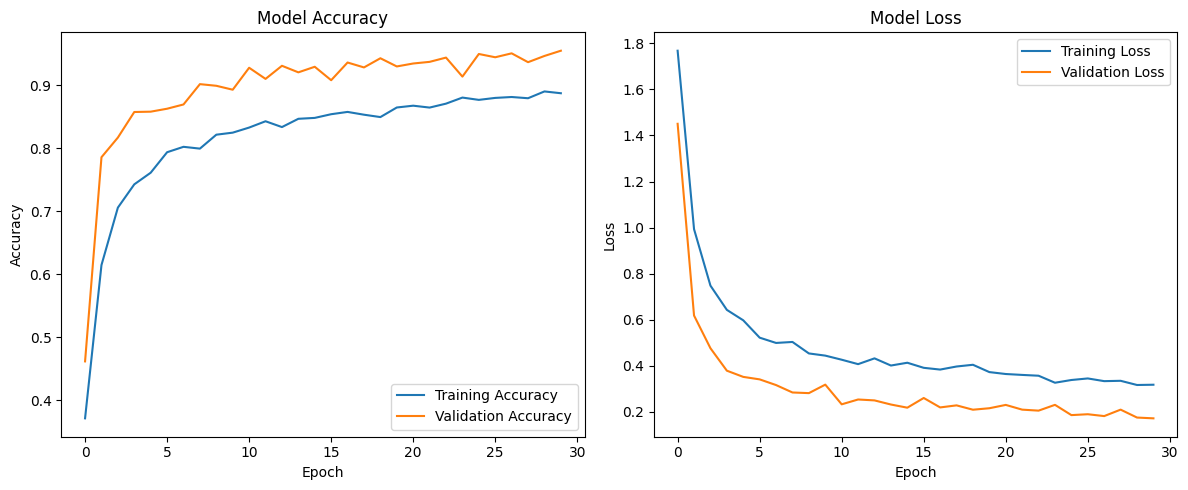

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


<Figure size 1000x800 with 0 Axes>

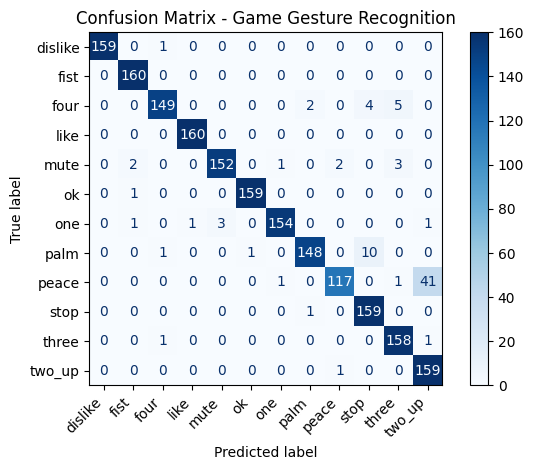


Game control mappings saved to processed_data/game_control_mappings.csv


,Gesture,Game Control
0,fist,Attack/Punch
1,palm,Move Forward
2,one,Select/Point
3,like,Power Up/Confirm
4,dislike,Crouch/Duck
5,peace,Special Move
6,ok,Pickup Item
7,stop,Pause Game
8,two_up,Jump
9,three,Weapon Switch



Testing model on sample JSON data...
Test JSON file not found: /content/drive/MyDrive/HandGestures/HAGRID/ann_test/fist_gesture_static_v1-v1.1/ann_fist_1.json
Using alternative test file: /content/drive/MyDrive/HandGestures/HAGRID/ann_test/ok.json

Testing model on 2391 annotations from /content/drive/MyDrive/HandGestures/HAGRID/ann_test/ok.json
Image ID: 0019e6cf-ba51-4a13-8a73-d91edde95f6f, Hand #1
  True gesture: ok
  Predicted gesture: ok (confidence: 1.00)
  Game action: Pickup Item
  Correct: True

Image ID: 002e5523-dd92-413f-8d7d-ed5968182ccb, Hand #1
  True gesture: ok
  Predicted gesture: ok (confidence: 1.00)
  Game action: Pickup Item
  Correct: True

Image ID: 003cd93c-b52f-4017-8653-a408638f9a57, Hand #2
  True gesture: ok
  Predicted gesture: ok (confidence: 0.91)
  Game action: Pickup Item
  Correct: True

Image ID: 003d8694-1a6a-4d26-8fcd-4cf3a988cfb8, Hand #1
  True gesture: ok
  Predicted gesture: ok (confidence: 1.00)
  Game action: Pickup Item
  Correct: True

Ima

,image_id,true_gesture,predicted_gesture,confidence,game_action,correct
0,0019e6cf-ba51-4a13-8a73-d91edde95f6f,ok,ok,0.999978,Pickup Item,True
1,002e5523-dd92-413f-8d7d-ed5968182ccb,ok,ok,1.000000,Pickup Item,True
2,003cd93c-b52f-4017-8653-a408638f9a57,ok,ok,0.905440,Pickup Item,True
3,003d8694-1a6a-4d26-8fcd-4cf3a988cfb8,ok,ok,0.999202,Pickup Item,True
4,00459cee-adac-4bb3-b80c-e2e41eb353a4,ok,ok,0.999830,Pickup Item,True
5,00472819-1805-4f5e-aeef-4e5a4aa24c20,ok,ok,1.000000,Pickup Item,True
6,0053fb7c-257d-4424-8a00-f82252e71e3d,ok,ok,0.999996,Pickup Item,True
7,0058246a-9a58-4753-b95a-d7dedb6aa71e,ok,ok,0.999930,Pickup Item,True
8,006af9ba-95c1-48f9-891d-bba5ba543378,ok,ok,0.818234,Pickup Item,True
9,0073a6a0-44c9-4fdb-9768-8c1ed80cec09,ok,ok,0.999999,Pickup Item,True


In [ ]:
# ============================================================
# EXECUTE THE ENTIRE PIPELINE
# ============================================================

print("STARTING HAGRID GAME GESTURE RECOGNITION PIPELINE")
print("=" * 50)

# Step 1: Preprocess dataset
X_train, X_test, y_train, y_test = preprocess_dataset()

# Step 2: Train model
model, history = train_model(X_train, X_test, y_train, y_test)

# Step 3: Visualize results
plot_training_history(history)
plot_confusion_matrix(model, X_test, y_test)
save_game_mappings()

# Step 4: Test on sample JSON file
print("\nTesting model on sample JSON data...")
test_json_file = os.path.join(hagrid_base_path, "ann_test/fist_gesture_static_v1-v1.1/ann_fist_1.json")
if os.path.exists(test_json_file):
    test_on_json_annotations(model, test_json_file)
else:
    print(f"Test JSON file not found: {test_json_file}")
    # Try to find any test JSON file
    for root, dirs, files in os.walk(os.path.join(hagrid_base_path, "ann_test")):
        for file in files:
            if file.endswith('.json'):
                test_json_file = os.path.join(root, file)
                print(f"Using alternative test file: {test_json_file}")
                test_on_json_annotations(model, test_json_file)
                break
        if os.path.exists(test_json_file):
            break
